In [ ]:
#dependencies
!sudo apt-get install texlive-xetex
!apt-get install poppler-utils
!pip install bitsandbytes
!pip install pdf2image

## NOTE:
To use LLama-3.1-8B, please do as follows:
1. Request access for Llama-3.1-8B on https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct
2. Go to profile and generate an access token
3. Press the next cell and insert your token

In [ ]:
!huggingface-cli login

In [ ]:

%cd ..
%cd NLP
import torch
from transformers import AutoTokenizer
from transformers import BitsAndBytesConfig

from lxt.models.llama_PE import LlamaForCausalLM, attnlrp
from lxt.utils import pdf_heatmap, clean_tokens

path = "meta-llama/Llama-3.1-8B-Instruct"


quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.bfloat16, # use bfloat16 to prevent numerical overflow
  )

model = LlamaForCausalLM.from_pretrained(path, torch_dtype=torch.bfloat16,quantization_config=quantization_config, device_map="cuda",attn_implementation="eager")
tokenizer = AutoTokenizer.from_pretrained(path)
model.gradient_checkpointing_enable()


attnlrp.register(model)

prompt = """\
The following is multiple choice question (with answers).

Which factor will most likely cause a person to develop a fever?
A. a leg muscle relaxing after exercise
B. a bacterial population in the bloodstream
C. several viral particles on the skin
D. carbohydrates being digested in the stomach

Please make sure to answer (A,B,C, or D)
Answer is:"""

input_ids = tokenizer(prompt, return_tensors="pt", add_special_tokens=True).input_ids.to(model.device)
input_embeds = model.get_input_embeddings()(input_ids)


position_ids = torch.arange(
                        0.0, input_ids.shape[1], device=input_embeds.device,  requires_grad=True,
                       dtype=torch.float32
                    ).reshape(1, -1)


position_embeddings = [model.get_input_pos_embeddings()(input_embeds, position_ids) for i in range(model.config.num_hidden_layers)]
position_embeddings = [(x[0].requires_grad_(),x[1].requires_grad_()) for x in  position_embeddings ]



output_logits = model(inputs_embeds=input_embeds.requires_grad_(),
                      position_embeddings = position_embeddings,
                      use_cache=False)['logits']

max_logits, max_indices = torch.max(output_logits[0, -1, :], dim=-1)



max_logits.backward(max_logits)


relevance = input_embeds.grad.float().sum(-1).cpu()[0]
acc_relevancy = 0.
num_pos_embed_layer = 2
for t, pos_embed in enumerate(position_embeddings):

    for i in range(num_pos_embed_layer):
        curr_relevancy = pos_embed[i].grad.float().sum(-1).cpu()[0]
        curr_relevancy = curr_relevancy.abs()
        acc_relevancy += curr_relevancy

relevance+=acc_relevancy
relevance = relevance / relevance.abs().max()






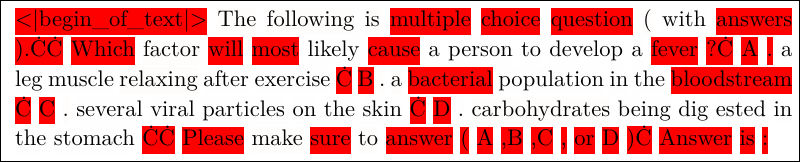

In [ ]:
# remove '_' characters from token strings and plot the heatmap

from pdf2image import convert_from_path, convert_from_bytes
from IPython.display import display, Image
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
tokens = clean_tokens(tokens)

num_elements = int(relevance.numel() * 0.5)
top_values, _ = torch.topk(relevance, num_elements)
top_values = top_values[-1].item()
relevance[relevance>top_values] = 1
pdf_heatmap(tokens, relevance, path='heatmapOurs.pdf', backend='xelatex')



# Replace with your PDF file path
pdf_file = "heatmapOurs.pdf"
images = convert_from_bytes(open(pdf_file, 'rb').read(), size=800)
display(images[0])

